Let's implement structure factor calculations for P1 lattices with a single atom type from scratch. 


The starting point is a crystal with cell constants $A, B, C, \alpha, \beta, \gamma$. The orthogonalization matrix,
$$
O = \begin{bmatrix}a & b\cos\gamma & c \cos\beta\\
0 & b\sin\gamma & \frac {c(\cos\alpha - \cos\beta\cos\gamma} {\sin\gamma} \\
0 & 0 & \frac {V} {ab\sin\gamma}
\end{bmatrix} \\
V = abc\sqrt{1 - \cos^2\alpha - \cos^2\beta -\cos^2\gamma + 2\cos\alpha\cos\beta\cos\gamma},
$$
can be used to convert from fractional to cartesian coordinates. The inverse of this matrix converts from cartesian, x,y,z, coordinates to fractional coordinates in the unit cell basis. 

The resolution of a reflection is
$$
d*_h = \frac {1}{d_h} = |(O^{-1})^Th|
$$

$$
F = \sum_j f_j e^{-2\pi i H\cdot x_j}
$$

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [214]:
a,b,c = 30, 40, 90
alpha,beta,gamma = 90, 90, 90

alpha,beta,gamma = np.deg2rad(alpha),np.deg2rad(beta),np.deg2rad(gamma)
V = a*b*c*np.sqrt(1 - np.cos(alpha)**2-np.cos(beta)**2 - np.cos(gamma)**2 + 
                  2*np.cos(alpha)*np.cos(beta)*np.cos(gamma))
O = [
    [a, b*np.cos(gamma), c*np.cos(beta)],
    [0, b*np.sin(gamma), c*(np.cos(alpha) - np.cos(beta)*np.cos(gamma))/np.sin(gamma)],
    [0, 0, V / (a*b*np.sin(gamma))],
]
Oinv = np.linalg.inv(O)
    
alpha,beta,gamma = np.rad2deg(alpha),np.rad2deg(beta),np.rad2deg(gamma)

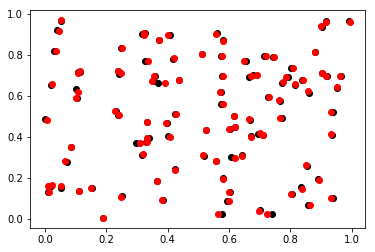

In [235]:
plt.plot(
    Xon[0][:,0],
    Xon[0][:,1],
    'ko',
)

plt.plot(
    Xoff[:,0],
    Xoff[:,1],
    'ro',
)

# Cromer-Mann coefficients for Carbon:

|i | 1 | 2 | 3 | 4 |
|--|---|---|---|---|
|a_i (e-) | 2.310 | 1.020 | 1.589 | 0.865 |
|b_i (A^2)| 20.844 | 10.208 | 0.569 | 51.651 |
|c   (e-)| 0.216 | ----- | ----- | ----- |


$f_j = \sum_{j=1}^4 a_j \cdot e^{-b_i(sin\theta / \lambda)^2+c}$

$\sin \theta/\lambda = \frac {1} {2 d_h}$

# Debye Waller Temperature Factors

$$
f_j^B = f_j \cdot T_j \\
T_j = e^{-B_j(\sin\theta/\lambda)^2}
$$

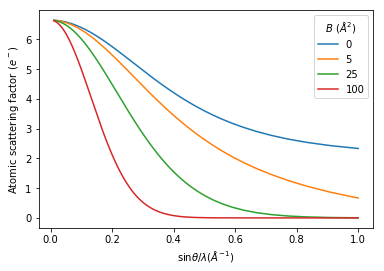

In [293]:
a_cm = np.array([2.310, 1.020, 1.589, 0.865])
b_cm = np.array([20.844, 10.208, 0.569, 51.651])
c_cm = 0.216

d = np.linspace(100, 1., 1000)

f = (a_cm[:,None]*np.exp(-b_cm[:,None]/(4*d*d)) + c_cm).sum(0)
B = np.array([0, 5, 25, 100])
T = np.exp(-B[:,None]/(4*d*d))

f.shape
plt.plot(1./d, (T*f).T)
plt.xlabel(r"$\sin \theta /\lambda (\AA^{-1})$")
plt.ylabel(r"Atomic scattering factor ($e^-$)")
plt.legend(B, title=r'$B\ (\AA^2)$')

In [326]:
num_particles = 100

#Temperature Factors
B = np.maximum(0, np.random.normal(20, 10, num_particles))

#Std deviation of coordinate jitter
std = 0.1#Angstroms

#Number of jitters to compute
iters = 1000

#Number of sample reflections
reflections=200

#Maximum h,k,l index range
hmax = 30


H = np.random.randint(0, hmax+1, (3, reflections))
while H.sum(0).min() == 0:
    H = np.random.randint(0, hmax+1, (3, reflections))
D = 1./np.linalg.norm(Oinv.T.dot(H), 2, 0)

#Random locations in fractional coordinates
Xoff = np.random.random((num_particles, 3))
#Convert to cartesian
Xoff = np.matmul(Xoff, O)
#Random jitter in cartesian space
DeltaX = np.random.laplace(0., std, (iters, num_particles, 3))
Xon = Xoff[None,:,:] + DeltaX

#Convert back to fractional coordinates
Xon = np.matmul(Xon, Oinv)
Xon = np.mod(Xon, 1.)
Xoff = np.matmul(Xoff, Oinv)

#Fourier transform
f = (a_cm[:,None]*np.exp(-b_cm[:,None]/(4*D*D)) + c_cm).sum(0)
T = np.exp(-B[:,None]/(4*D*D))
Foff = (T*f*np.exp(-1j*2*np.pi*Xoff.dot(H))).sum(-2)
Fon = (T*f*np.exp(-1j*2*np.pi*Xon.dot(H))).sum(-2).T
DeltaF = Fon - Foff[:,None]

Text(0, 0.5, '$|\\Delta F|$')

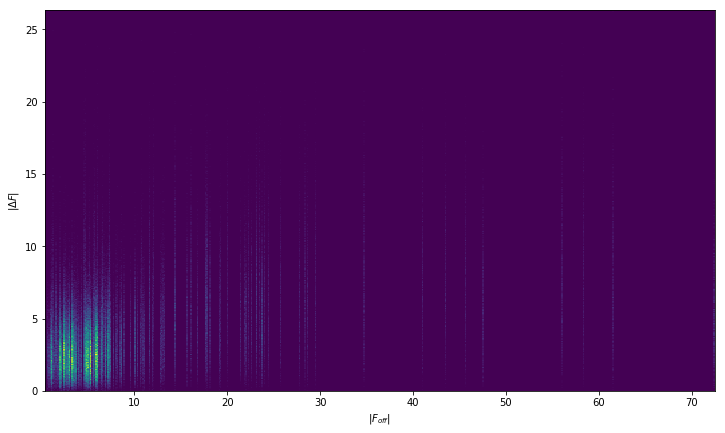

In [327]:
plt.figure(figsize=(12, 7))
_ = plt.hist2d((np.abs(Foff)[:,None]*np.ones(Fon.shape)).flatten(), np.abs(DeltaF).flatten(), 500)
plt.xlabel(r"$|F_{off}|$")
plt.ylabel(r"$|\Delta F|$")

Text(0, 0.5, '$\\angle \\Delta F - \\angle F_{off}$')

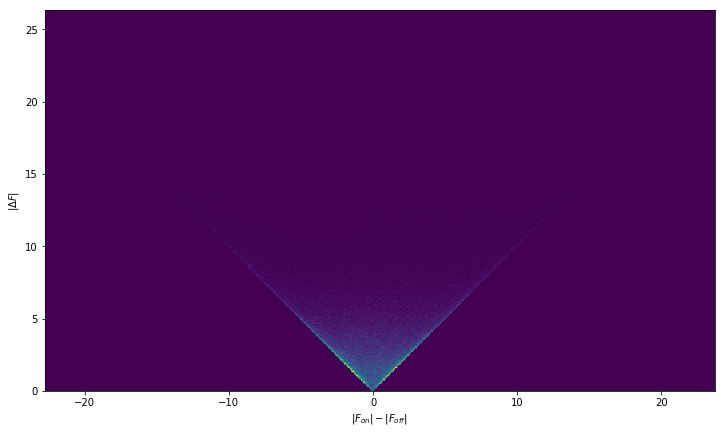

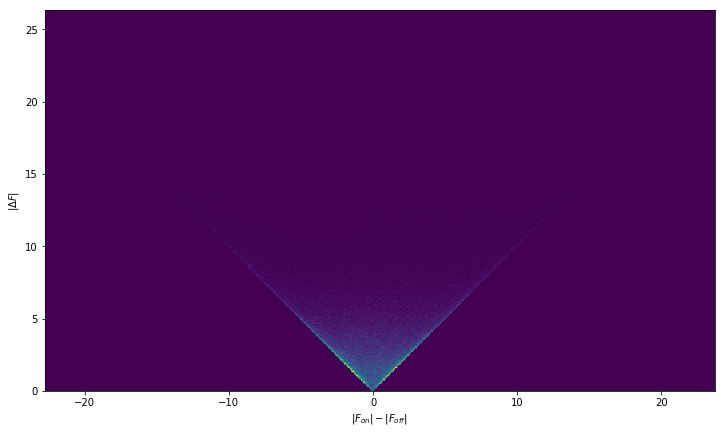

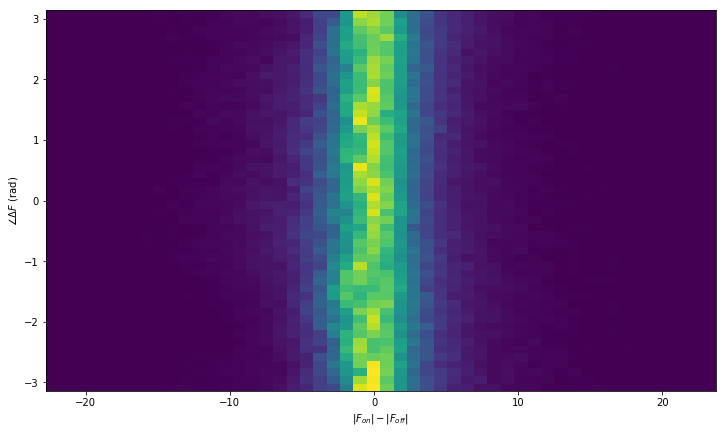

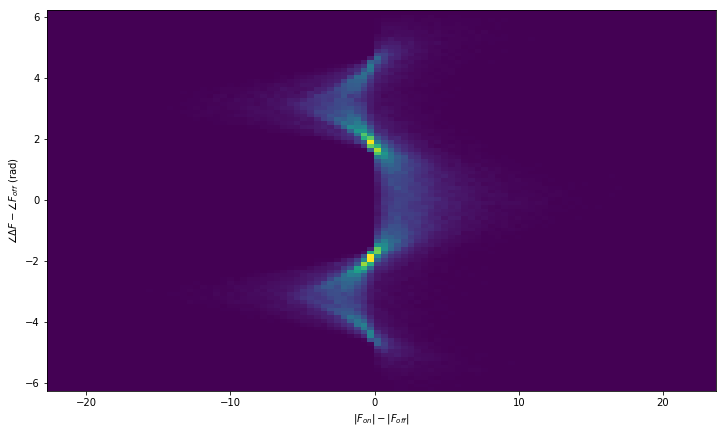

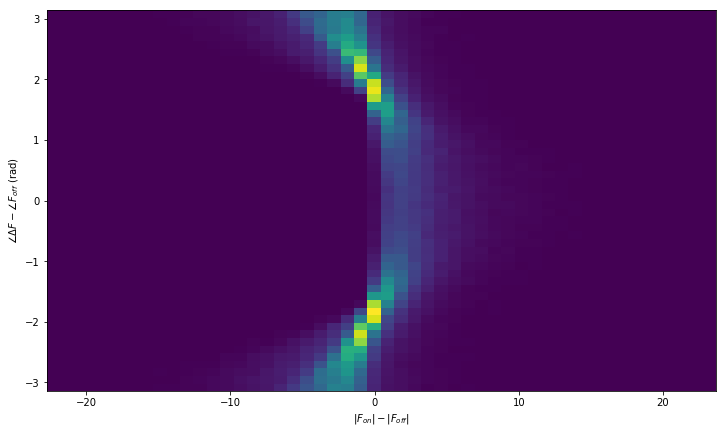

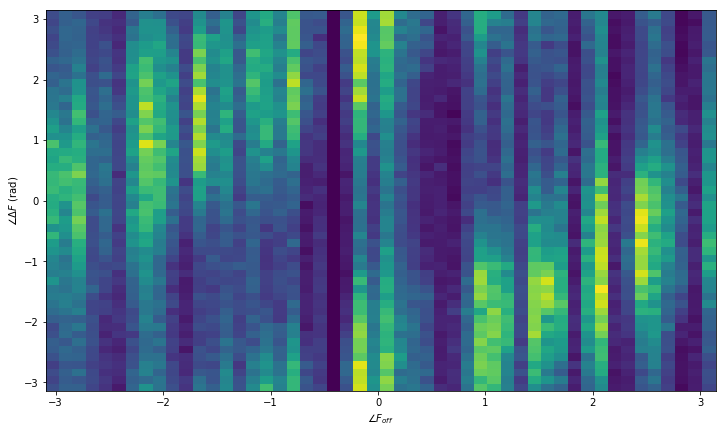

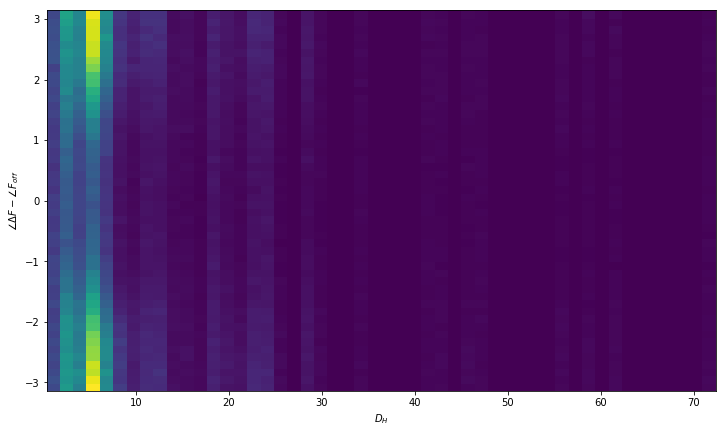

In [328]:
plt.figure(figsize=(12, 7))
_ = plt.hist2d((np.abs(Fon) - np.abs(Foff)[:,None]*np.ones(Fon.shape)).flatten(), np.abs(DeltaF).flatten(), 500)
plt.xlabel(r"$|F_{on}| - |F_{off}|$")
plt.ylabel(r"$|\Delta F|$")

plt.figure(figsize=(12, 7))
_ = plt.hist2d((np.abs(Fon) - np.abs(Foff)[:,None]*np.ones(Fon.shape)).flatten(), 
               np.abs((Foff/np.abs(Foff))[:,None]*DeltaF).flatten(), 500)
plt.xlabel(r"$|F_{on}| - |F_{off}|$")
plt.ylabel(r"$|\Delta F|$")


plt.figure(figsize=(12, 7))
_ = plt.hist2d((np.abs(Fon) - np.abs(Foff)[:,None]*np.ones(Fon.shape)).flatten(), np.angle(DeltaF).flatten(), 50)
plt.xlabel(r"$|F_{on}| - |F_{off}|$")
plt.ylabel(r"$\angle \Delta F$ (rad)")


plt.figure(figsize=(12, 7))
_ = plt.hist2d((np.abs(Fon) - np.abs(Foff)[:,None]*np.ones(Fon.shape)).flatten(), 
               (np.angle(DeltaF) - np.angle(Foff)[:,None]).flatten(), 100)
plt.xlabel(r"$|F_{on}| - |F_{off}|$")
plt.ylabel(r"$\angle \Delta F - \angle F_{off}$ (rad)")



plt.figure(figsize=(12, 7))
_ = plt.hist2d(
    (np.abs(Fon) - np.abs(Foff)[:,None]*np.ones(Fon.shape)).flatten(), 
    np.angle(DeltaF*np.exp(-1j*np.angle(Foff))[:,None]).flatten(),
    50,
)
plt.xlabel(r"$|F_{on}| - |F_{off}|$")
plt.ylabel(r"$\angle \Delta F - \angle F_{off}$ (rad)")




plt.figure(figsize=(12, 7))
_ = plt.hist2d(
    np.angle(Foff[:,None]*np.ones(DeltaF.shape)).flatten(), 
    np.angle(DeltaF).flatten(),
    50,
)
plt.xlabel(r"$\angle F_{off}$")
plt.ylabel(r"$\angle \Delta F$ (rad)")


plt.figure(figsize=(12, 7))
_ = plt.hist2d(
    (np.abs(Foff)[:,None]*np.ones(Fon.shape)).flatten(),
    np.angle(DeltaF*np.exp(-1j*np.angle(Foff))[:,None]).flatten(),
    50,
)
plt.xlabel(r"$D_H$")
plt.ylabel(r"$\angle \Delta F - \angle F_{off}$")

Text(0, 0.5, '$|\\Delta F|$ Error')

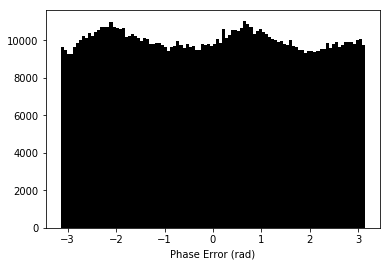

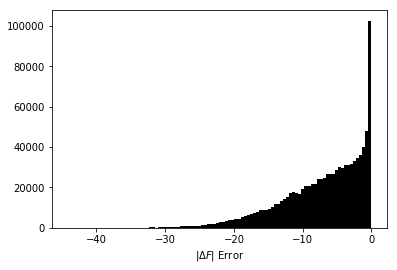

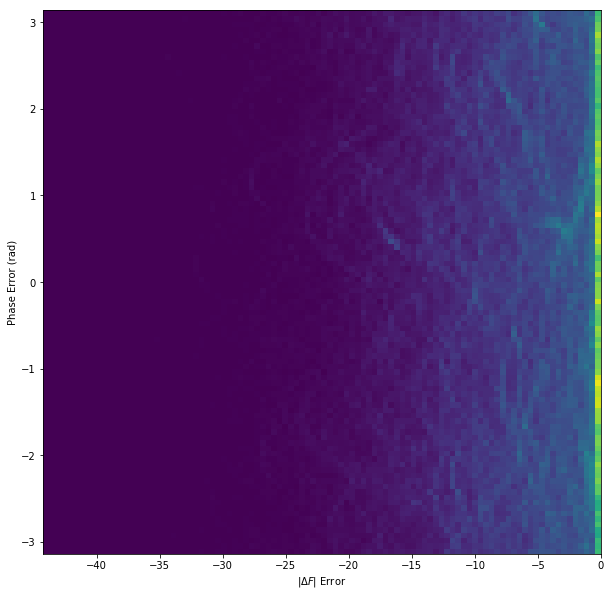

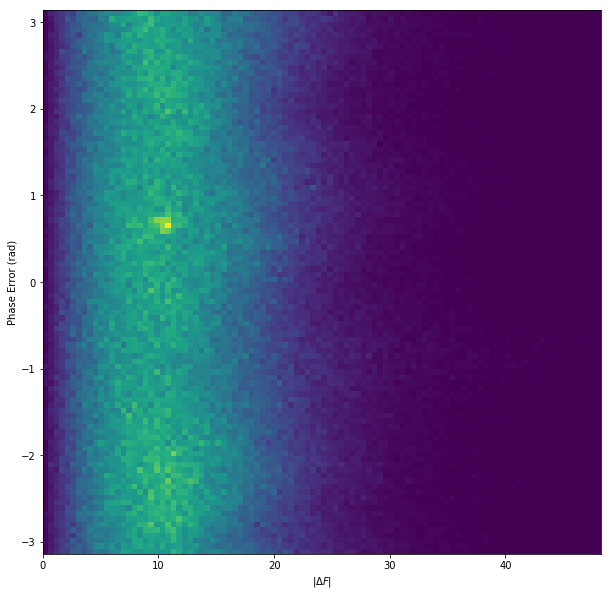

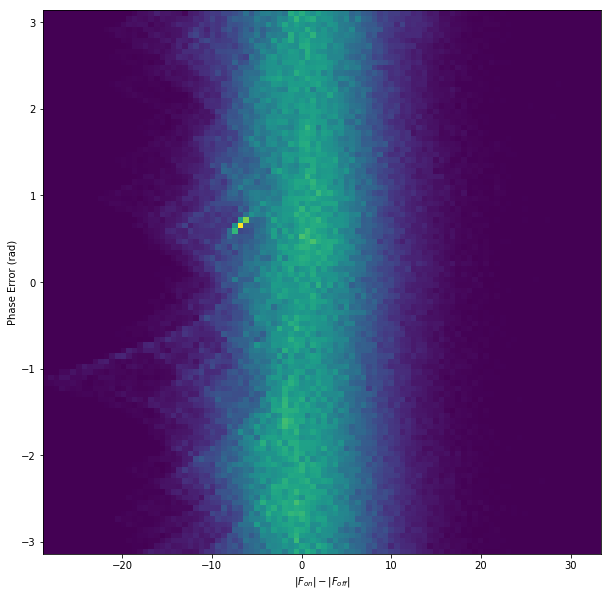

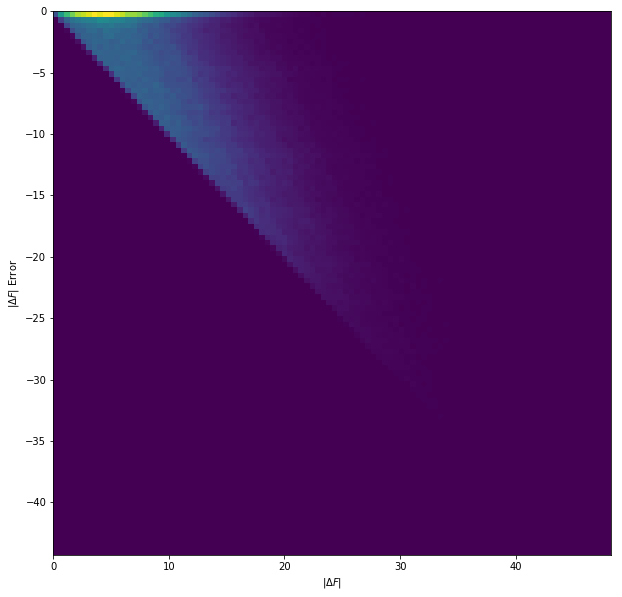

In [207]:
fobs = np.abs(Fon) - np.abs(Foff)[:,None]
phobs = (fobs < 0.)*np.pi + np.angle(Foff)[:,None]
pherr = np.angle(np.exp(1j*phobs)*np.exp(1j*np.angle(DeltaF)))
_ = plt.hist(pherr.flatten(), 100, color='k')
plt.xlabel('Phase Error (rad)')

plt.figure()
ferr = np.abs(np.abs(Fon) - np.abs(Foff)[:,None]) - np.abs(DeltaF)
_ = plt.hist(ferr.flatten(), 100, color='k')
plt.xlabel('$|\Delta F|$ Error')

plt.figure(figsize=(10,10))
plt.hist2d(ferr.flatten(), pherr.flatten(), 100)
plt.xlabel('$|\Delta F|$ Error')
plt.ylabel('Phase Error (rad)')


plt.figure(figsize=(10,10))
plt.hist2d(np.abs(DeltaF).flatten(), pherr.flatten(), 100)
plt.xlabel('$|\Delta F|$')
plt.ylabel('Phase Error (rad)')

plt.figure(figsize=(10,10))
plt.hist2d(fobs.flatten(), pherr.flatten(), 100)
plt.xlabel('$|F_{on}| - |F_{off}|$')
plt.ylabel('Phase Error (rad)')


plt.figure(figsize=(10,10))
plt.hist2d(np.abs(DeltaF).flatten(), ferr.flatten(), 100)
plt.xlabel('$|\Delta F|$')
plt.ylabel('$|\Delta F|$ Error')

Text(0.5, 0, '$\\Delta \\phi$')

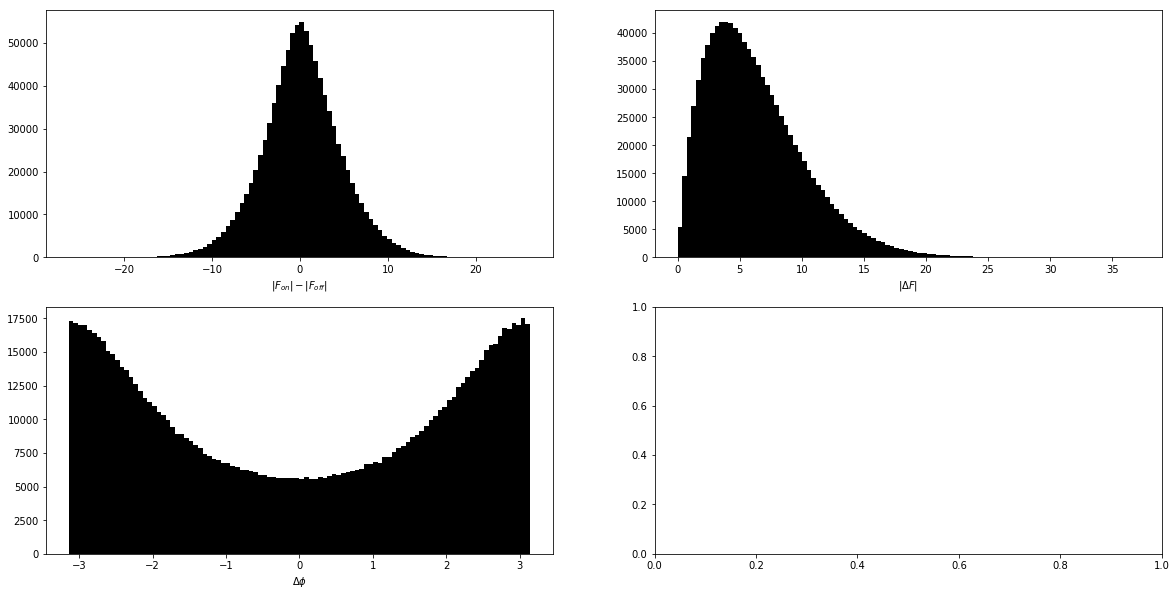

In [241]:


f,((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(20,10))

plt.sca(ax1)
plt.hist((np.abs(Fon) - np.abs(Foff)[:,None]).flatten(), 100, color='k')
plt.xlabel("$|F_{on}| - |F_{off}|$")

plt.sca(ax2)
plt.hist(np.abs(Fon - Foff[:,None]).flatten(), 100, color='k')
plt.xlabel("$|\Delta F|$")

plt.sca(ax3)
plt.hist(np.angle(DeltaF*np.exp(-1j*np.angle(Foff))[:,None]).flatten(), 100, color='k')
plt.xlabel("$\Delta \phi$")



Median: 0.017232719024307855
Mean: 0.3551029102110311


Text(0, 0.5, '$\\sigma_{(|F_{on}| - |F_{off}|)/|F_{off}|}$')

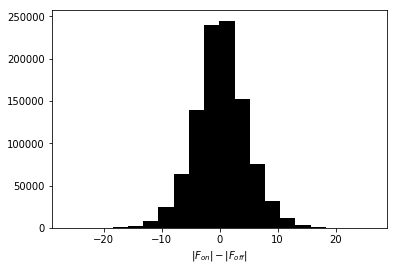

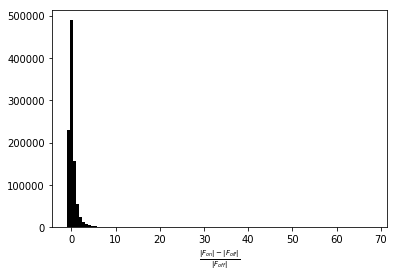

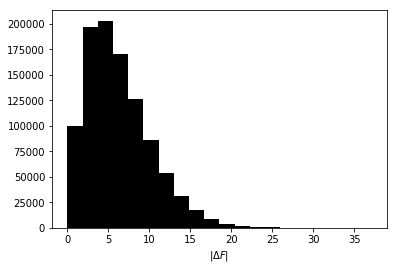

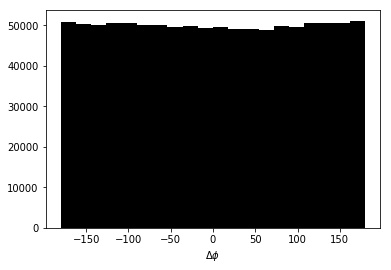

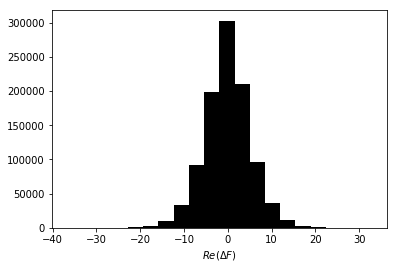

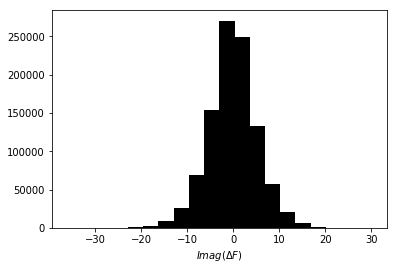

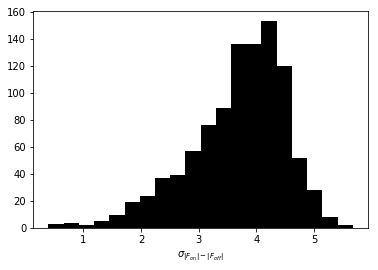

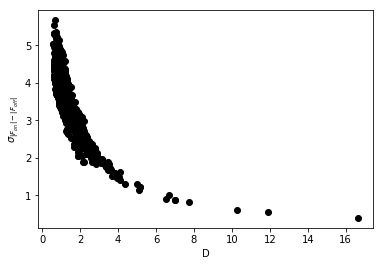

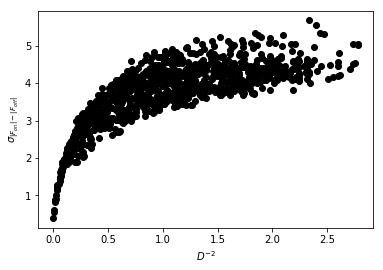

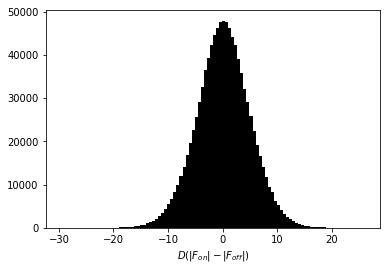

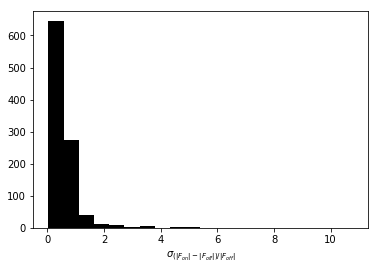

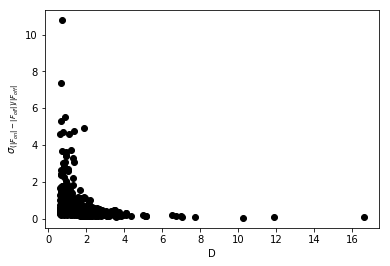

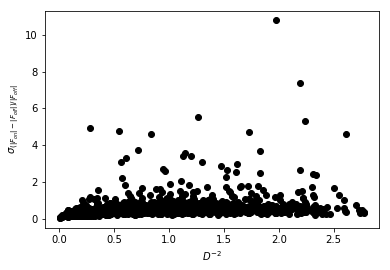

In [240]:


plt.figure()
plt.hist((np.abs(Fon) - np.abs(Foff)[:,None]).flatten(), 20, color='k')
plt.xlabel("$|F_{on}| - |F_{off}|$")

DeltaFoverF = (((np.abs(Fon) - np.abs(Foff)[:,None]))/(np.abs(Foff)[:,None])).flatten()
print(f"Median: {np.median(DeltaFoverF)}")
print(f"Mean: {DeltaFoverF.mean()}")
plt.figure()
plt.hist((((np.abs(Fon) - np.abs(Foff)[:,None]))/(np.abs(Foff)[:,None])).flatten(), 100, color='k')
plt.xlabel(r"$\frac {|F_{on}| - |F_{off}|}{|F_{off}|}$")

plt.figure()
plt.hist(np.abs(DeltaF).flatten(), 20, color='k')
plt.xlabel("$|\Delta F|$")
plt.figure()
plt.hist(np.rad2deg(np.angle(DeltaF)).flatten(), 20, color='k')
plt.xlabel("$\Delta \phi$")
plt.figure()
plt.hist(np.real(DeltaF).flatten(), 20, color='k')
plt.xlabel("$Re(\Delta F)$")
plt.figure()
plt.hist(np.imag(DeltaF).flatten(), 20, color='k')
plt.xlabel("$Imag(\Delta F)$")


std = (np.abs(Fon) - np.abs(Foff)[:,None]).std(1)
plt.figure()
plt.hist(std, 20, color='k')
plt.xlabel("$\sigma_{|F_{on}| - |F_{off}|}$")

plt.figure()
plt.plot(D, std, 'ko')
plt.xlabel("D")
plt.ylabel("$\sigma_{|F_{on}| - |F_{off}|}$")

plt.figure()
plt.plot(D**-2, std, 'ko')
plt.xlabel("$D^{-2}$")
plt.ylabel("$\sigma_{|F_{on}| - |F_{off}|}$")

plt.figure()
plt.hist((D[:,None]*(np.abs(Fon) - np.abs(Foff)[:,None])).flatten(), 100, color='k')
plt.xlabel("$D (|F_{on}| - |F_{off}|)$")


std = ((np.abs(Fon) - np.abs(Foff)[:,None])/np.abs(Foff)[:,None]).std(1)
plt.figure()
plt.hist(std, 20, color='k')
plt.xlabel("$\sigma_{(|F_{on}| - |F_{off}|)/|F_{off}|}$")

plt.figure()
plt.plot(D, std, 'ko')
plt.xlabel("D")
plt.ylabel("$\sigma_{(|F_{on}| - |F_{off}|)/|F_{off}|}$")

plt.figure()
plt.plot(D**-2, std, 'ko')
plt.xlabel("$D^{-2}$")
plt.ylabel("$\sigma_{(|F_{on}| - |F_{off}|)/|F_{off}|}$")

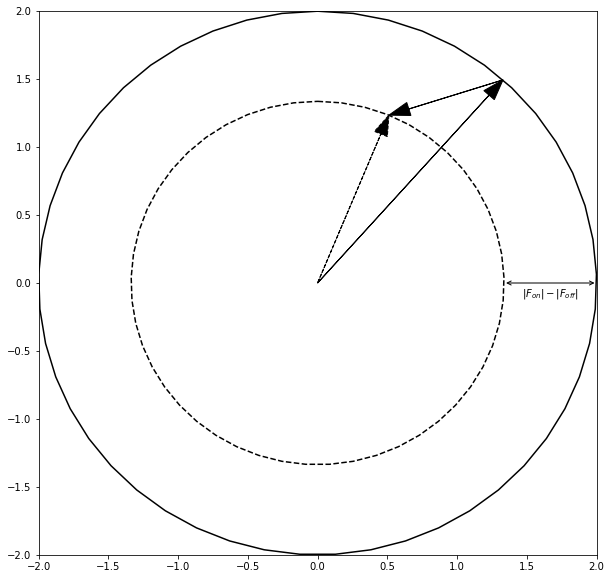

In [210]:
Foff = 2*np.exp(2j*np.pi*np.random.random())
DeltaF = np.random.normal(1.0, 0.1)*np.exp(1j*(2*np.pi*np.random.random()))
Fon = Foff + DeltaF

plt.figure(figsize=(10,10))
plt.arrow(0., 0., np.real(Foff), np.imag(Foff), color='k', length_includes_head=True, head_width=0.1)
plt.arrow(0., 0., np.real(Fon), np.imag(Fon), color='k', linestyle='--', length_includes_head=True, head_width=0.1)
plt.arrow(np.real(Foff), np.imag(Foff), np.real(DeltaF), np.imag(DeltaF), color='k', length_includes_head=True, head_width=0.1)
lim = np.max([
    np.abs(Foff),
    np.abs(Fon),
])
plt.xlim((-lim, lim))
plt.ylim((-lim, lim))

plt.plot(
    np.abs(Foff)*np.sin(np.linspace(0, 2*np.pi)),
    np.abs(Foff)*np.cos(np.linspace(0, 2*np.pi)),
    '-k',
)

plt.plot(
    np.abs(Fon)*np.sin(np.linspace(0, 2*np.pi)),
    np.abs(Fon)*np.cos(np.linspace(0, 2*np.pi)),
    '--k',
)

plt.annotate(s='', xy=(
    np.min((np.abs(Fon), np.abs(Foff))), 0,
), xytext=(
    np.max((np.abs(Fon), np.abs(Foff))), 0,
), arrowprops=dict(arrowstyle='<->'))

plt.text(
    np.mean((np.abs(Fon), np.abs(Foff))), -0.1,
    r'$|F_{on}| - |F_{off}|$', horizontalalignment='center'
)


    

plt.show()